# Skill of Rain Probability Forecasting
20 February 2023
$\newcommand{ob}{\overline{o}}$  $\newcommand{obk}{\overline{o}_k}$ $\newcommand{oki}{o_{ki}}$
$\newcommand{ee}{\mathrm{EE}}$  $\newcommand{vs}{\mathrm{VS}}$ 


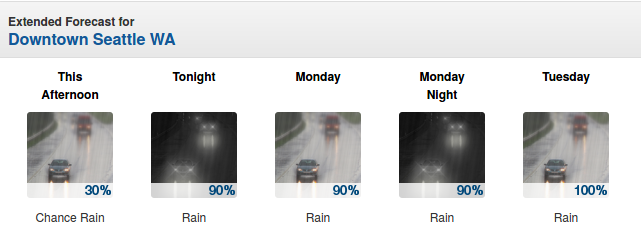
How good are these [probabilty of precipitation](https://en.wikipedia.org/wiki/Probability_of_precipitation) (PoP) forecasts? Either rainfall will be above a specified amount (0.1 mm for US National Weather Service), so an event called "rain" occurs, or below the specified amount, so the event is "no rain". If "no rain" occurs, and the forecast was for 30% chance of rain, is the forecast wrong? How good are these forecasts?  If forecasting 30% PoP means that on 100 days where you forecast PoP=30%, we expect to find on 30 such days it rained, the forecasts were perfectly *reliable*.  But are the forecast customers supposed to be satisfied with that? 

Let's explore the value of probability forecasts.  A prerequisite for this notebook is my [ ForecastSkill.ipynb](https://anaconda.org/bfiedler/forecastskill)

The *Brier score* $\mathbf{BS}$  is a familiar mean square error:
\begin{eqnarray}
\Huge \mathbf{BS} &\Huge =& \Huge \frac{1}{N} \sum_{i=1}^N (p_i-o_i)^2\\
\end{eqnarray}
$p_i$ is a forecasted *probability*, $0<=p_i<=1$. <br>
$o_i$ is a binary *observation*, either $1$ or $0$, for did/didn't occur.

Obviously, if you are not restricting forecasts to only 100% or 0% probability, your forecasts can never be perfect, meaning $\mathbf{BS}>0$. Hopefully the forecast will be better than just forecasting from *climatology*, meaning using a frequency from previous years as the value for $p_i$.

I admit that using $o$ as a symbol for a variable is normally not recommended, but $o$ is for *observation*.

In [1]:
import os
from urllib.request import urlopen
import matplotlib.pyplot as plt
from datetime import datetime as dt
utc=dt.utcfromtimestamp
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [2]:
%%html
<style> div.text_cell_render{background-color: #ded; font-size: 18px}
                    .rendered_html code {background-color: #ded; color: #900;font-size: 16px}
                    .rendered_html pre {background-color: #ded; color: #900; font-size: 16px} 
</style>

In [3]:
# for automatically downloading data files from http://metr4330.net/data/, or other URL
def grabfile(urlfront,filename,filedir=""): # filedir could be data/, for example
    urlpath = urlfront+filename
    filepath = filedir+filename
    if os.path.exists(filepath):
        print(filepath," already exists.  Delete it, if you want to overwrite.")
        return
    with urlopen(urlpath) as response:
        body = response.read()
    with open(filepath,'wb') as f:
        f.write(body)
    print("downloaded "+urlpath+" to "+filepath)
    return

In [4]:
#choose file:
infilename="31011_DailyPoP1.csv" ; raintrigger=1 # 1 mm
#infilename="31011_DailyPoP10.csv" ; raintrigger=10 # 10 mm

#choose forecast (f1 = 1 day, f2 = 2 day)
fx='f1'
#fx='f2'

In [5]:
# download the data file, if needed  
if not os.path.exists(infilename):
    grabfile("http://metr4330.net/data/",infilename)
else:
    print("you already have "+infilename)

you already have 31011_DailyPoP1.csv


In [6]:
yourname="metrprof" # Put your username here in the quotes, for your figures. Your name is not metrprof

In [7]:
sitenum=infilename.split('_')[0] # grabs sitenum from the filename you chose
siteinfo={
    '31011':'CAIRNS AERO',
    '12038':'KALGOORLIE-BOULDER AIRPORT',
    '09021':'PERTH AIRPORT'
}
sitename=siteinfo[sitenum]
print("this is what you are studying:")
print(sitenum)
print(sitename)
print("probability of daily rainfall greater than",raintrigger," mm")

this is what you are studying:
31011
CAIRNS AERO
probability of daily rainfall greater than 1  mm


In [8]:
lines=open(infilename).readlines()
for line in lines: 
    print(line,end='')

   utc         ob   clim   f1    f2    f3    f4    f5    f6    f7
1430406000    0.0    49    NA    NA    NA    NA    NA    NA    NA 
1430492400    0.0    33     4    NA    NA    NA    NA    NA    NA 
1430578800    0.0    33     3     6    NA    NA    NA    NA    NA 
1430665200    0.0    33    14     0     7    NA    NA    NA    NA 
1430751600    0.0    33     1     0     0     4    NA    NA    NA 
1430838000    0.0    33     9     3     3     2    10    NA    NA 
1430924400    0.0    33    15    16    18    13    13    28    NA 
1431010800    0.2    33    18    11    12    26    21    28    27 
1431097200    0.0    33     1     8    12    14    21    21    27 
1431183600    0.0    33    13    21    21    19    16    16    16 
1431270000    0.0    33     1    10    10     9     8     9     9 
1431356400    0.0    33     0     2     2     1     7    12    12 
1431442800    0.0    33     0     6     0     1     1     3     1 
1431529200    0.0    33    12    12     8     3     7    19    

`ob` is daily rainfall in mm, `utc` is the start of the day, `clim` is the climatological frequency of rainfall above the `raintrigger` for that month, and `f1`...`f7` are the PoP forecasts issued 1 ... 7 days prior. 


See my notebook  `ForecastSkill.ipynb`

In [9]:
colnames = lines[0].strip().split()
print(colnames)
fkeys=colnames[3:] 
print(fkeys)

['utc', 'ob', 'clim', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']
['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7']


In [10]:
edictf={} # the "e" means everything: obs,climate and forecast for the utc
for line in lines[1:]: #skip header line
    q=line.strip().split()
    timeob = int(q[0]) # the utc of the ob
    edictf[timeob] = {} # make a dictionary within a dictionary
    ncol=len(colnames)
    for n in range(1,ncol):
        k=colnames[n] # the key
        v=q[n] # the value
        if v!='NA': 
            if k=='ob':
                v=float(v)
            else: # probability is percent, so convert
                v=float(v)/100.
        edictf[timeob][k]=v
ekeys=sorted(edictf)
print(" edictf has",len(ekeys),"keys")

 edictf has 365 keys


In [11]:
testkey=ekeys[100]
print( testkey )
print( utc(testkey) ) # utc converts epoch time to UTC time
print( edictf[testkey] )

1439046000
2015-08-08 15:00:00
{'ob': 0.0, 'clim': 0.15, 'f1': 0.02, 'f2': 0.08, 'f3': 0.08, 'f4': 0.09, 'f5': 0.09, 'f6': 0.2, 'f7': 0.04}


In [12]:
gkeys=[] #gkeys are "good" keys
for k in ekeys:
    d=edictf[k]
    if 'NA' in [ d['ob'],d['clim'],d['f1'],d['f2'] ]: continue
    gkeys.append(k) # no NA in values
print("number of keys =",len(ekeys),"    number of keys with no missing values NA",len(gkeys))  

number of keys = 365     number of keys with no missing values NA 340


Next we round all the probabilities to 1 decimal place.  So the forecasts will not be the official Australian forecasts, but our own modification of the forecasts.  So $p_i$ is rounded to 0, 0.1, 0.2 ...1.0.  All the observations of rain  amount is compared with the *rain trigger* value, and the observation is assigned as 0 or 1. All the these observations are grouped with the respective probability of the forecast, in a dictionary `verif`.

In [13]:
# Calculate Brier skill scores BS. Also round the probability for later use.
verif={}  
bsc=0. # Brier score using climatology for forecast probability
bs1=0. # Brier score for f1 forecasts
bs2=0. # Brier score for f2 forecasts
n=0 # counter
for k in gkeys:
    d = edictf[k]
    ob = d['ob']
    clim = d['clim']
    f1 = d['f1']
    f2 = d['f2']
    rained = int(ob>=raintrigger) # will be 1 or 0
    bs1 += (rained-f1)**2  
    bs2 += (rained-f2)**2
    bsc += (rained-clim)**2
    n += 1
    fp=round(d[fx],1) # fp used later, fx is f1 or f2. chosen above
    if fp not in verif:
        verif[fp]=[rained] # start the list 
    else:
        verif[fp].append(rained) # grow the list 
bs1 = bs1/n
bs2 = bs2/n
bsc = bsc/n
print("N =",n)

N = 340


In [14]:
print("Brier score for climatological forecast bsc=%5.2f" % (bsc))
print("Brier score for f1 forecast bs1=%5.2f "%(bs1))
print("Brier score for f2 forecast bs2=%5.2f "%(bs2))

Brier score for climatological forecast bsc= 0.22
Brier score for f1 forecast bs1= 0.13 
Brier score for f2 forecast bs2= 0.15 


You may see in the above that one and two day forecasts have better (lower) Brier score than forecasting with climatology.

A popular way to compare the Brier scores is to make a *Brier skill score* $\mathbf{BSS}$:
$$
\mathbf{BSS} = 1 - \frac{\mathbf{BS}}{\mathbf{BS_{clim}}}
$$
A perfect forecast will have $\mathbf{BSS}=1$, a forecast no better than climatology will have $\mathbf{BSS}=0$

In [15]:
#Brier skill scores BSS
bss1 = 1.-bs1/bsc
bss2 = 1.-bs2/bsc
print("Brier skill score for f1 bss1=%5.2f"%(bss1))
print("Brier skill score for f2 bss2=%5.2f"%(bss2))

Brier skill score for f1 bss1= 0.40
Brier skill score for f2 bss2= 0.33


Are the 30% probability forecasts reliable? Was rain recorded in 30% of the days that were forecasted with PoP=0.3?  Let's see:   

In [16]:
# inspect and understand verif
for PoP in sorted(verif):
    print("PoP=",PoP,"  rains=",verif[PoP])

PoP= 0.0   rains= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
PoP= 0.1   rains= [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
PoP= 0.2   rains= [0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1]
PoP= 0.3   rains= [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0]
PoP= 0.4   rains= [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0]
PoP= 0.5   rains= [1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]
PoP= 0.6   rains= [1, 1, 1, 1, 0, 0, 

Notice and understand how the original data file has been distilled into `verif`, which is printed above. We proceed with the above `verif` to assess the forecast skill. 

In [17]:
#make obk and obar, importance wil be explained below
obk = {}
obar = 0 
N = 0
for PoP in sorted(verif):
    rains = verif[PoP] # the 1s and 0s
    obk[PoP] = sum(rains)/len(rains) # average of rains
    obar += sum(rains)
    N += len(rains)
obar = obar/N # average of all rains

In [18]:
print(N,obar)

340 0.3382352941176471


In [19]:
# obk is verif, but with the average of rains
for PoP in sorted(obk):
    print(PoP,obk[PoP])

0.0 0.0
0.1 0.03076923076923077
0.2 0.14634146341463414
0.3 0.25
0.4 0.6153846153846154
0.5 0.8333333333333334
0.6 0.7
0.7 0.8461538461538461
0.8 0.9
0.9 1.0


Next we decompose $\mathbf{BS}$ into three terms: *reliability*, *resolution* and *uncertainty*. The decomposition aids in interpreting the result.  The appendix shows, with a very long derivation, that:

\begin{eqnarray}
\mathbf{BS} &=& \frac{1}{N} \sum_{i=1}^N (p_i-o_i)^2\\
&=& \frac{1}{N} \sum_{k=1}^K  n_k (p_k -\obk)^2 - \frac{1}{N} \sum_{k=1}^K n_k (\obk -\ob)^2 +  \ob(1  - \ob) \\
&=& \mathbf{RELIABILITY}-\mathbf{RESOLUTION}+\mathbf{UNCERTAINTY} \\
&=& \mathbf{RELI}-\mathbf{RESO}+\mathbf{UNC} \\
\end{eqnarray}

Here we have $K$ groups of forecasts, with each group having been forecasted with the same probability $p_k$.   $\obk$ is the average of all (number $n_k$) observations $o_i$, all the 1's and 0's, that occurred in that group forecasted with $p_k$. The average of all $N$ of  $o_i$ is denoted $\ob$.

In our python, `obk` is $\obk$, `obar` is $\ob$ and $p_k$ are the keys to `obk`. 

As an extreme example, suppose you use $K=1$. In this case, $o_1=\ob$.   Suppose you always forecast with $p_1$ as the annual climatological frequency, known from previous years weather.   If you are lucky, $\ob$ for the year is the $p_1$ you used. If so, $\mathbf{RELI}=0$, a perfect contribution to $\mathbf{BS}$. Likewise $\mathbf{RESO}=0$. So in this case $\mathbf{BS}=\mathbf{UNC}$, which depends only on the average observations, $\ob$.

Note, this warning: 
> "The presence of the uncertainty term means that Brier Scores should not be compared on different samples."

I will express that differently: It is relatively easy to get low Brier scores for forecasts of events that are either very frequent,  $\ob \approx 1$, or very rare $\ob \approx 0$.  Though forecast systems for such events will produce a low $\mathrm{BS}$, they are not necessarily better, more clever, or more skillful than  forecasts systems that produce higher $\mathrm{BS}$ for a different type of event with $\ob \approx 0.5$.

By the way, I would prefer to call $\mathbf{RELIABILITY}$ the $\mathbf{UNRELIABILITY}$.The larger the value, the more unreliable the forecast, increasing $\mathbf{BS}$, so a worse forecast. But I am not allowed to change the conventional name. 

Note *un* prefix in the word *uncertainty*. That makes sense to me.  

And note $-\mathbf{RESOLUTION}$.  With the minus sign, the greater the $\mathbf{RESOLUTION}$, the better the forecast.

Need a reference? This might help: [Ensemble Forecasts and their
Verification](https://www2.atmos.umd.edu/~ekalnay/syllabi/AOSC630/ensemble101.pdf).  Especially page 11 and beyond.

In [20]:
#calculate BS again, using rounded probabilities, but without using RELI RESO UNC
N=0
BSa=0
for PoP in sorted(verif):
    rains=verif[PoP]
    for o in rains:
        BSa+=(PoP-o)**2
        N+=1
BSa=BSa/N
print("BSa=",BSa,"   recall BS without rounding probabilities:",bs1) 

BSa= 0.13388235294117626    recall BS without rounding probabilities: 0.13415529411764698


In [21]:
#calculate BS using RELI RESO UNC decomposition, use obk and obar
unc=obar*(1-obar)
reli=0
reso=0
for PoP in sorted(verif):
    n=len(verif[PoP])
    reli += n*(PoP-obk[PoP])**2
    reso += n*(obk[PoP]-obar)**2
reli=reli/N
reso=reso/N
print("RELI=",reli,"  RESO=",reso,"  UNC=",unc)

RELI= 0.01888189309494905   RESO= 0.10883172008456844   UNC= 0.22383217993079585


In [22]:
BSb = reli - reso + unc

In [23]:
print("BSa=",BSa,"BSB=",BSb,BSa-BSb) # compare BSa with BSb.  Should be equal, except for rounding error.

BSa= 0.13388235294117626 BSB= 0.13388235294117645 -1.942890293094024e-16


Let's prepare to plot a [reliability diagram](https://openi.nlm.nih.gov/detailedresult?img=PMC4032526_rsif20131162-g1&req=4). Although named *reliability*, the diagram also shows resolution and uncertainty.  Sorry, but I didn't name the diagram...

In [24]:
# make lists to plot the reliability diagram 
nobs=[] # dot size proportional to nobs
colors=[] # indicates positive or negative skill
freqs=[] # the y values
pops=[] # the x values
for PoP in sorted(verif):
    n=len(verif[PoP])
    nobs.append(n)
    freq = obk[PoP]
    freqs.append(freq)
    pops.append(PoP)
    if abs(freq-obar) < abs(freq-PoP): #for dot color
        colors.append('b') # blue means negative skill
    else: 
        colors.append('r') # red means positive skill    

In [25]:
# calculate bias of the forecasts
# note the number of forecasts nf for rain events is NOT necessarily an integer
nf=0
nr=0
for PoP in sorted(verif):
    rains=verif[PoP]
    nr += sum(rains) # number of rain events
    nf += len(rains)*PoP  # number of forecasts for rain events
bias=nf/nr
print("number of forecasts for rain=",nf,"   number rain events=",nr,"   bias=",bias)    

number of forecasts for rain= 99.6    number rain events= 115    bias= 0.8660869565217391


BS=0.134   RELI=0.019   RESO=0.109 UNC=0.224   BSS=0.397   Bias=0.866
reliability_1_f1.png


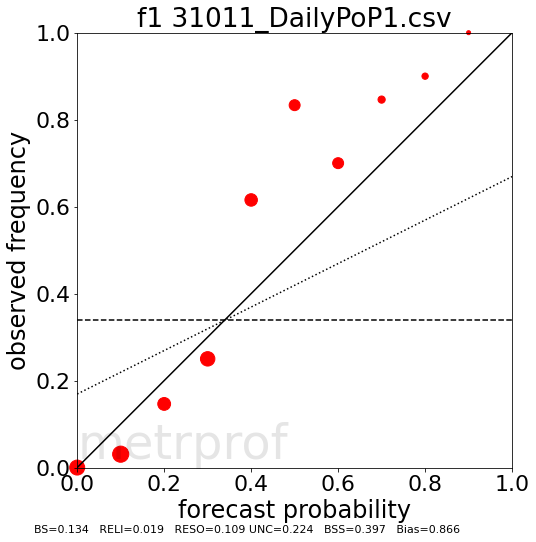

In [26]:
# Plot the reliability diagram

dotmult = 4 # for scaling dot size in reliability diagram
dpi = 98 # smaller value makes smaller PNG plot
caption_form="BS={:5.3f}   RELI={:5.3f}   RESO={:5.3f} \
UNC={:5.3f}   BSS={:5.3f}   Bias={:5.3f}"
caption_string = caption_form.format(BSa,reli,reso,unc,bss1,bias)
print(caption_string)
dotsize = [dotmult*x for x in nobs] # make dot area proportional to number of obs 

quick, simple = plt.subplots(figsize=(8,8))
simple.scatter(pops,freqs,s=dotsize,c=colors,clip_on=False)
simple.plot([0.,1.],[obar,obar],'k--') # climatology forecast
simple.plot([0.,1.],[0,1],'k-') # perfect forecast
simple.plot([0.,1.],[obar/2., (1+obar)/2.],'k:') # the no-skill line
simple.set_aspect('equal')
simple.set_xlim([0,1]) 
simple.set_ylim([0,1])
simple.set_title(fx+" "+infilename)
simple.set_ylabel('observed frequency',fontsize=24)
simple.set_xlabel('forecast probability',fontsize=24)
simple.text( -.1, -.15, caption_string, fontsize=11, transform=simple.transAxes) 
# http://wiki.scipy.org/Cookbook/Matplotlib/Transformations
simple.text(0.,0.02,yourname,fontsize=48, alpha=.1, transform = simple.transAxes) 

pngname = "reliability_{:d}_{:}.png".format(raintrigger,fx)
print(pngname)
quick.savefig(pngname,dpi=dpi)

Note in the [reliability diagram](https://openi.nlm.nih.gov/detailedresult?img=PMC4032526_rsif20131162-g1&req=4), only points in the grey area contribute to positive skill, meaning a lower value BS.  In our plot above, a red dot indicates a positive contribution to skill, blue indicates a negative contribution. A *no-skill line* is indicated as a dotted line, which provides a bound for the grey area seen in [reliability diagram](https://openi.nlm.nih.gov/detailedresult?img=PMC4032526_rsif20131162-g1&req=4).  A derivation of the *no-skill line* is shown in the Appendix.

# Relative Operating Characteristic

As a consumer of PoP forecasts, you may want to know whether you should: ride your bike to work tomorrow, pour concrete tomorrow, water your lawn tonight, reserve an indoor tennis court, bring and umbrella tomorrow.  All this actions are binary.  Knowing the statistical reliability of the forecasts may not be useful to you.

Suppose for your activity, you assume a threshold PoP, for example 0.65. That means for PoP greater than the threshold you take action, with the presumption that rain will occur. For PoP less than the threshold you presume no rain will occur. Which value of PoP is best for you? Ultimately, that depends on the cost of being wrong in your personal forecast.

The first step in determining the best threshold PoP is to make a [ROC]( https://www.metoffice.gov.uk/research/climate/seasonal-to-decadal/gpc-outlooks/user-guide/interpret-roc) curve.  Here is another [concise summary of ROC curves](https://www.swpc.noaa.gov/content/roc-receiver-operating-characteristic-curves). The reason for the name *Receiver Operating Characteristic* is a bit obscure in the application to weather forecasts. But in meteorology we  commonly refer to the ROC curve. It is your choice to use the name *Relative* or *Receiver*.   

A larger area under the ROC curve implies your forecast system is more skillful: [(https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)



The placement of a point on a ROC curve is derived from the contingency table for each threshold, from which get a hit rate and false alarm rate.
For educational purposes, we print out the contingency tables for all these points.
For the variable names used below.
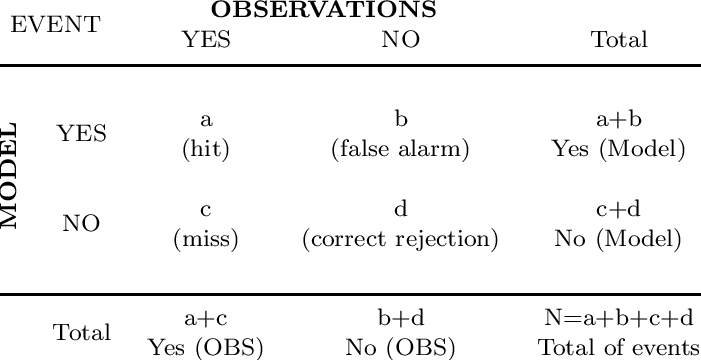
This hit rate is $a/(a+c)$.  The false alarm rate is $b/(b+d)$.

## Relative Value (or Value Score VS)
Have we found forecast skill in the ROC curve? If so, we move onto saving money (reducing anguish) by using an optimal PoP to make a binary decision. Let $\ee$ be the *expected expense*, 
averaged over many daily decisions, for using a certain threshold PoP. We will compare $\ee$ over all possible thresholds. $C$ is the cost of taking the action, presuming the event will occur. $L$ is the loss, the cost if the event occurs, but no action was taken. These number could be in dollars, or any currency.  The ratio $\gamma=C/L$ is what is important in the determination of the *value score* $\vs$ (Wilks 7.82):

$$\vs = \frac{\ee_{clim}-\ee_{forecast}}{\ee_{clim}-\ee_{perf}}=\frac{\ee_{forecast}-\ee_{clim}}{\ee_{perf}-\ee_{clim}}$$

With a *perfect* forecast, there are no loss events,  all events are perfectly anticipated:

$$ \ee_{perf} = C\ob $$

Using the actual forecast,
$$ \ee_{forecast} = C\frac{a+b}{n}  + L\frac{c}{n} $$

Suppose no forecasts are available, and no monthly climate data is known. All that is known is the annual $\ob$.
How do we calculate $EE_{clim}$? There are two possibilities for action to take for all days in the year.
Let $\gamma=C/L$.
If $\gamma<\ob$, the best strategy is to always take action, with cost $C$ every day:

$$ \ee_{clim}=C  $$

$$\vs = \frac{ \gamma\left( \frac{a}{n} + \frac{b}{n}\right) + \frac{c}{n}  - \gamma}{ \gamma\ob - \gamma }$$


If $\gamma>\ob$, the best strategy is to never take action, and let nature take its course:

$$ \ee_{clim}=L\ob  $$

$$\vs = \frac{ \gamma\left( \frac{a}{n} + \frac{b}{n}\right) + \frac{c}{n}  - \ob}{ \gamma\ob - \ob }$$

Note this special case: if the threshold is increased above the value at which no action will be taken, both $a=0$ and $b=0$ and
 $\ee_{forecast} = L\frac{c}{n} = L\ob$ .  At $\gamma>\ob$, the numerator of $\mathrm{VS}$ is 0.
 
(I find some confusion between the terms Value Score and Relative Value.  I think they mean the same thing https://journals.ametsoc.org/view/journals/wefo/20/4/waf871_1.xml )

In [27]:
# computations for ROC plot and Relative Value plot
climo = obar  # Note this! Sample climatology is being used as climatology.
print("climo=",climo)
# initialize empty lists
thresholds=[] # threshold probability to trigger action assuming rain
hitrates=[] 
farates=[] 
PoPs = sorted(verif.keys()) # all the PoP 

# for Relative value plot:
cls=[n/100. for n in range(1,100) ] # C/L's , for relative value curves
rvs=[] # will be list of lists, each list defines a curve for a given threshold 

thresholds=[-.001]+[PoP +.05 for PoP in PoPs]
# from Wilks Fig 7.1: a=hits TP   b=false positives FP   c=misses FN   d=true negatives TN
print("make contingency table for each treshold:\n")
for threshold in thresholds :  
    a = 0 # TP
    b = 0 # FP
    c = 0 # FN
    d = 0 # TN
    for PoP in PoPs:
        q = verif[PoP] # list of 1s and 0s, the rain events
        lq = len(q) # number of events
        sq = sum(q) # number of positive events (1s) 
        n += lq
        if PoP <= threshold: # the PoP is less than the threshold, forecast no rain
            c += sq # misses, false negative
            d += lq - sq # true negative
        else: # the PoP is above the threshold, forecast rain
            a += sq # hits, true positive
            b += lq - sq # false positive
# see Wilks 7.11 and 7.13 for distinction between FA rate and ratio!!
# b /(a+b) ) # false alarm RATIO, not correct for RoC
# hitrates and farates for the threshold:
    hitrate = a/(a+c)
    farate = b/(d+b)
    cstr1="threshold={:6.3f}   hitrate={:6.3f}  farate={:6.3f}".format(threshold,hitrate,farate)
    cstr2="  a={:d}  b={:d}\n  c={:d}  d={:d}\n".format(a,b,c,d)
    print(cstr1)
    print(cstr2)
    
# save for ROC curve:
    hitrates.append(hitrate)
    farates.append( farate ) # false alarm RATE, which is correct for RoC curve
            
# Wilks page 324, Value Score
# EE means expected expense
# C is cost (in dollars)
# L is loss (in dollars)
# EE_perfect= C*climo 
# if cl<=climo, take action on all days: EE_clim = C 
# if cl>=climo, do nothing based on climo: EE_clim = L*climo 
# EE_forecast: C*a + C*b - L *c
# vs = (EE_forecast - EE_clim)/(EE_perfect - EE_clim)
# In the following, all terms are divided by L, so you see ratio cl=C/L
    n = a+b+c+d
    rv=[] # will be a list of value score, for the threshold
    for cl in cls:
        if cl<climo: 
            vs = ( cl*( a/n + b/n) + c/n  -cl )/( cl*climo - cl )
        else:
            vs = ( cl*( a/n + b/n) + c/n - climo )/( cl*climo - climo)
        rv.append(vs)
    rvs.append(rv) # rvs is list of all lists rv, for plotting         

climo= 0.3382352941176471
make contingency table for each treshold:

threshold=-0.001   hitrate= 1.000  farate= 1.000
  a=115  b=225
  c=0  d=0

threshold= 0.050   hitrate= 1.000  farate= 0.751
  a=115  b=169
  c=0  d=56

threshold= 0.150   hitrate= 0.983  farate= 0.471
  a=113  b=106
  c=2  d=119

threshold= 0.250   hitrate= 0.930  farate= 0.316
  a=107  b=71
  c=8  d=154

threshold= 0.350   hitrate= 0.817  farate= 0.142
  a=94  b=32
  c=21  d=193

threshold= 0.450   hitrate= 0.609  farate= 0.076
  a=70  b=17
  c=45  d=208

threshold= 0.550   hitrate= 0.391  farate= 0.053
  a=45  b=12
  c=70  d=213

threshold= 0.650   hitrate= 0.209  farate= 0.013
  a=24  b=3
  c=91  d=222

threshold= 0.750   hitrate= 0.113  farate= 0.004
  a=13  b=1
  c=102  d=224

threshold= 0.850   hitrate= 0.035  farate= 0.000
  a=4  b=0
  c=111  d=225

threshold= 0.950   hitrate= 0.000  farate= 0.000
  a=0  b=0
  c=115  d=225



In [28]:
# Before we plot the ROC curve, we calculate area under the ROC curve,
# the AUC, using the trapezoidal rule.  Bigger area implies better forecasts.
auc=0. 
for n in range( len(hitrates) -1 ):
    auc += -.5*(hitrates[n+1]+hitrates[n])*(farates[n+1]-farates[n])
aucf= "%5.4f" % auc # will be included in plot title
print(aucf)

0.8991


ROC_1_f1.png


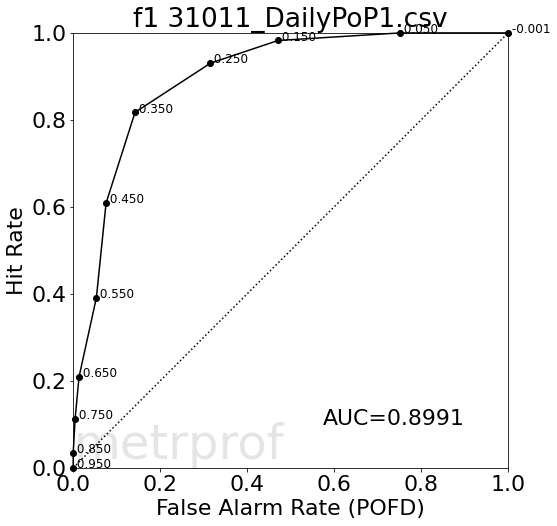

In [29]:
# plot and label the ROC curve
mfig, ax = plt.subplots(figsize=(8,8))
ax.plot(farates,hitrates,'ok-',clip_on=False)
ax.plot([0.,1.],[0,1],'k:')
ax.set_title(fx+" "+infilename)
ax.set_xlabel('False Alarm Rate (POFD)')
ax.set_ylabel('Hit Rate')
ax.set_aspect('equal') # square plot
ax.set_xlim([0,1])
ax.set_ylim([0,1])
i=0
for x,y in zip(farates,hitrates):
    threshold = ' %5.3f' % thresholds[i]
    ax.text(x,y,threshold,fontsize=12) # label each point in ROC with threshold
    i += 1
ax.text(0.9,.1,'AUC='+aucf,ha='right')
ax.text(0.,0.02,yourname,fontsize=48, alpha=.1, transform = ax.transAxes)
pngname = "ROC_{:d}_{:}.png".format(raintrigger,fx)
print(pngname)
mfig.savefig(pngname,dpi=dpi)


Relative value curves
m= 0    threshold= -0.001   max rv= -0.000
m= 1    threshold= 0.050   max rv= 0.249
m= 2    threshold= 0.150   max rv= 0.511
m= 3    threshold= 0.250   max rv= 0.612
m= 4    threshold= 0.350   max rv= 0.674
m= 5    threshold= 0.450   max rv= 0.533
m= 6    threshold= 0.550   max rv= 0.338
m= 7    threshold= 0.650   max rv= 0.195
m= 8    threshold= 0.750   max rv= 0.109
m= 9    threshold= 0.850   max rv= 0.035
m= 10    threshold= 0.950   max rv= -0.000
RelaVal_1_f1.png


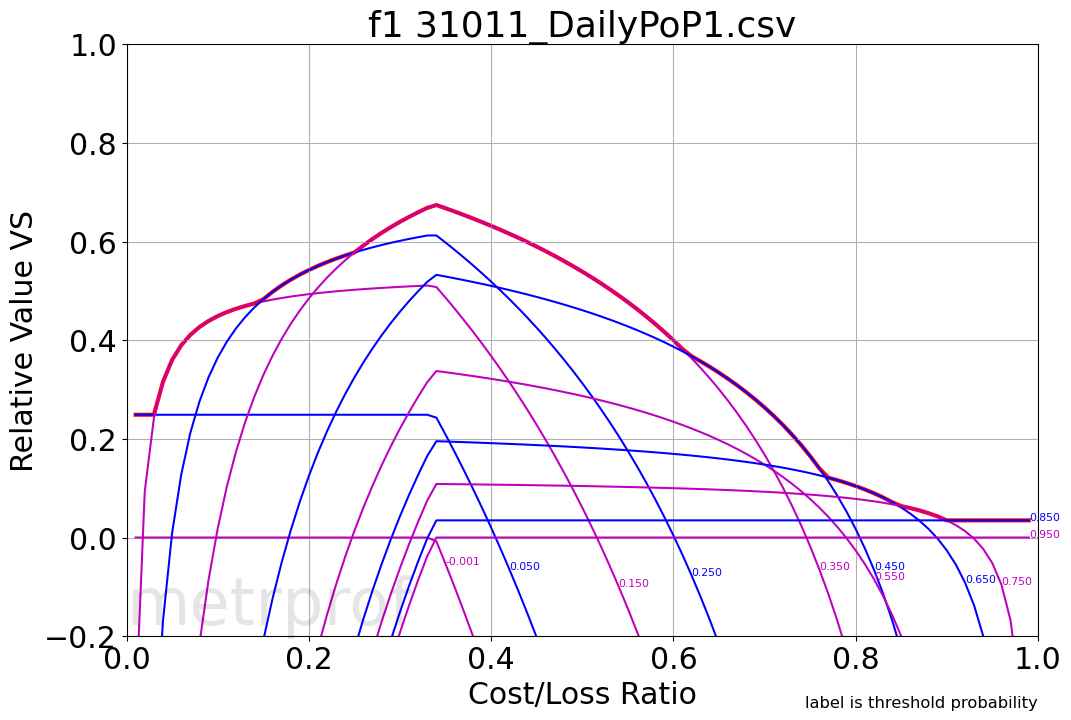

In [30]:
# plot relative value curves
thefig, bx = plt.subplots(figsize=(12,8),dpi=dpi)

rvmax=[] # list for envelope curve, plotted in red
for i in range(len(rvs[0])): # cycle through each C/L
    rvmax.append( max([ rv[i]  for rv in rvs]) ) # max at the C/L
    
m=0
print("\nRelative value curves")
for rv in rvs: # plot relative value curve for each threshold
    threshold = '%5.3f' % thresholds[m]
    maxrv = '%5.3f' % max(rv)
    print("m=",m,"   threshold=",threshold,"  max rv=",maxrv)
    if m%2:
        bx.plot(cls,rv,'b-')
    else:
        bx.plot(cls,rv,'m-')
    
# place the label on the curve, not easy   
    xy = list(zip(cls,rv)) #prepare to make labels
    xy.reverse() # (x,y) coordinates are now from right to left
    for x,y in xy :
        if y>-.1: # put label at first x point from right where y>-.05 
            bx.text(x,y,threshold,fontsize=8,color='mb'[m%2]) # label each curve with threshold
            break #stop looking for place to put label
    m+=1

bx.plot(cls,rvmax,'r-',lw=3,zorder=0) #red envelope; zorder=0 puts it under other curves
#bx.plot([0.,1.],[0,0],'b:',lw=3)
bx.set_xlim( [0,1] ) # shortcut for axes().set_xlim([0,1])
bx.set_ylim( [-.2,1] )
bx.set_xlabel("Cost/Loss Ratio")
bx.set_ylabel("Relative Value VS")
bx.set_title(fx+" "+infilename)
bx.grid(True)
bx.text(1.0,-0.12,"label is threshold probability",fontsize=12, ha='right',transform = bx.transAxes)
bx.text(0.,0.02,yourname,fontsize=48, alpha=.1, transform = bx.transAxes)
pngname = "RelaVal_{:d}_{:}.png".format(raintrigger,fx)
print(pngname)
thefig.savefig(pngname,dpi=dpi)

For example, if your cost is $C=\mathrm{$}6$ to bring an umbrella when you expect rain, and your loss is $L=\mathrm{$}10$ when it rains on you without your umbrella, your $C/L$ ratio is 0.6. 
Using `infilename="31011_DailyPoP1.csv" ; raintrigger=1.`;  `fn=f1`, we see at
at $C/L=0.6$, that the maximum Relative Value is about 0.4.  The red envelope curve is coincident with the curve labeled 0.350. So the maximum economic benefit occurs if you use a PoP of 35% for your threshold to bring an umbrella. This means you should bring your umbrella only when the PoP is forecasted to be above 35%. The Relative Value VS of 0.4 means the expense savings (dollars) of using these probability forecasts (and you using the best probability threshold of .35 to take action)  is 40% of the expense savings of using perfect forecasts. 

If, for your $C/L$ ratio, there is no threshold probability that give VS>0, then the probability forecasts should be ignored. You should just use knowledge of the climatology of the event.  As stated above, if $C/L<\ob$, the best strategy is to always take action, with cost $C$ every day.  If $C/L>\ob$, the best strategy is to never take action, let nature take its course, and take the loss.

<hr style="height:30px;border:none;background-color:#f00;" />

# Student Exercises
## 1. 2-day forecast for 10 mm of rain

Something simple. Use the switches for `fx` and `infilename` to study the four Relative Value plots. 
Post the animated gif of the four plots on your secret web page.
Here is my animated gif:  http://metr4330.net/~bfiedler/secret/probability/ Here is how I made it on the server:
```
    $ pwd
    /home/bfiedler/public_html/secret/probability
    $ ls
    index.html         RelaVal_10_f2.png  RelaVal_1_f2.png
    RelaVal_10_f1.png  RelaVal_1_f1.png
    $ convert -delay 200 -loop 0 RelaVal_* RelaVal.gif
    $ ls
 
```

Problems with overprinting because of transparency in your PNGs? Try this:
```
   $ convert -delay 200 -loop 0 -dispose Background RelaVal_* RelaVal.gif


```


In contrast to the other three cases, there is something distinctive about the Relative Value plot for the 2-day forecast for 10 mm of rain. Distinctive, meaning for some of the forecast clients with C/L greater than a critical value, there is no threshold value of probability that leads to VS>0, which means $\ee_{forecast}\ge\ee_{clim}$. In a caption to
your `RelaVal.gif`, state what the critical value is that we see, and state what clients should always do if their C/L is greater than that critical value. Specifically, should those clients always prepare for rain and endure the cost of preparation, or should they never prepare for rain and just suffer the expense of the loss due to rain?

Assume those clients need more than 24 hours to prepare for a rain event, so the 1-day forecast is not useful to them.


## 2. Optimal probability threshold
For a given C/L (or $\gamma$)  what threshold probability gives the highest Relative Value?  With the above plot, that question can be answered by finding C/L on the x-axis, and moving upward to find the curve that has the highest Relative Value, and then tracing that curve down to the labeled threshold probability.  Let's do that "finding" task for the forecast user. Make a plot of optimal threshold probability vs C/L, for `fx='f2'` with `31011_DailyPoP1.csv`. Post that plot on your secret web page.  Here is mine for `fx='f1'`.

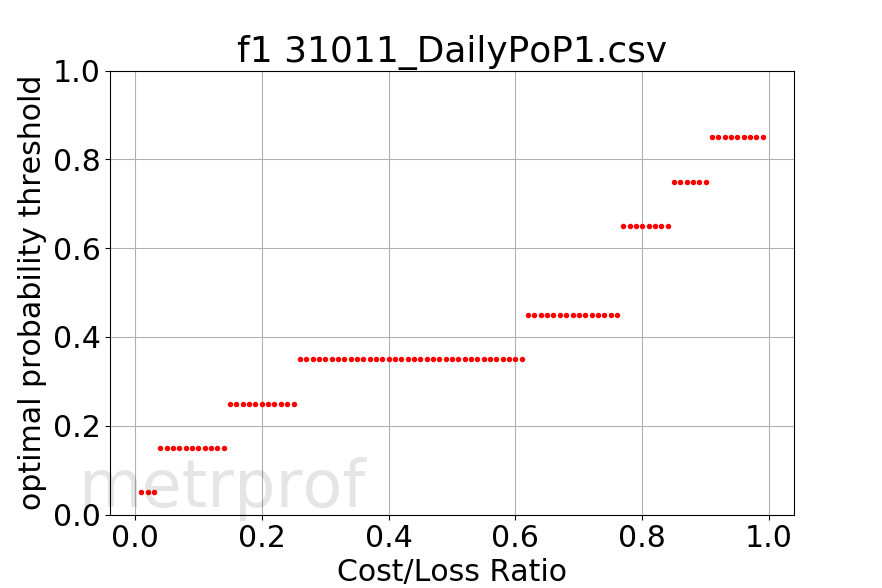

In a previous semester, many students struggled to find the coordinates of the 100 red dots.  So here is a very big hint:
```
opts=[]
for i in range(len(cls)):
    cl=cls[i]
    bestt = thresholds[0]
    rvm=rvs[0][i]
    for j in range(1,len(thresholds)):
        rv=rvs[j][i]
        if rv>rvm:
            rvm=rv
            bestt=thresholds[j]
    print(cl,bestt)
    opts.append(bestt)
```

## 3. Adding bias information to relidiag
When we plotted the *reliability diagram* earlier in this notebook, we built on computations done in many previous cells.  Below in function `relidiag`, I have gathered those computations together in a function.  It is not quite complete.  You need to add the computation for `bias`.  When you are done, post the reliability diagram for contestant `c10` (in the  quiz) on your secret web page.



In [31]:
def relidiag(verif,bsclimo=None,title="",tag="",dpi=98,dotmult=40,signature="",plot=True):    
    obar=0
    bs=0
    N=0
    obk={}
    nobs=[]
    freqs=[]
    #Students: increment nr and nf within this loop, then calculate bias
    nr = 0 #number of rain events, initialize to 0
    nf = 0. #number of forecasted rain events, initialize to 0
    for PoP in sorted(verif):
        rains = verif[PoP]
        n = len(rains)
        N += n
        sumrains = sum(rains)
        obar += sumrains
        obk[PoP] = sumrains/n
        nr += 0 # 0 is not correct! Students fix.
        nf += 0 #  0 is not correct! Students fix. nf is not an integer in probability forecast
    bias= None # None is not correct! Use the nf and nr you calculated above
    obar = obar/N
    unc = obar*(1-obar)
    nobs=[] # dot size proportional to nobs
    colors=[] # indicates positive or negative skill
    freqs=[] # the y values
    pops=[] # the x values
    reli = 0.
    reso = 0.
    for PoP in sorted(verif):
        n = len(verif[PoP])
        nobs.append(n)
        freq = obk[PoP]
        freqs.append(freq)
        pops.append(PoP)
        if abs(freq-obar) < abs(freq-PoP): #for dot color
            colors.append('b') # blue means no skill
        else: 
            colors.append('r') # red means skill    
        reli += n*(PoP-freq)**2
        reso += n*(freq-obar)**2
        
    reli=reli/N
    reso=reso/N
    bs=reli-reso+unc
    if not plot: 
        return reli,reso,unc,bs
    caption_form="RELI={:5.3f}   RESO={:5.3f}   UNC={:5.3f}  BS={:5.3f}  "
    caption_string = caption_form.format(reli,reso,unc,bs)
    if bias!=None: 
        caption_string+= " BIAS={:6.3f} ".format(bias)
    if bsclimo:
        bss = 1-bs/bsclimo
        bssf="  BSS={:5.3f}".format(bss)
        caption_string+=bssf
    
    dotsize = [dotmult*x for x in nobs] # make dot area proportional to number of obs 

    afig, simple = plt.subplots(figsize=(8,8))
    simple.scatter(pops,freqs,s=dotsize,c=colors,clip_on=False)
    simple.plot([0.,1.],[obar,obar],'k--') # climatology forecast
    simple.plot([0.,1.],[0,1],'k-') # perfect forecast
    simple.plot([0.,1.],[obar/2., (1+obar)/2.],'k:') # the no-skill line
    simple.set_aspect('equal')
    simple.set_xlim([0,1]) 
    simple.set_ylim([0,1])
    simple.set_title(title ,y=1.01,fontsize=18)
    simple.set_ylabel('observed frequency',fontsize=24)
    simple.set_xlabel('forecast probability',fontsize=24)
    simple.text(.1,.9,tag,fontsize=24)
    simple.text( -.0, -.15, caption_string, fontsize=14, transform=simple.transAxes) 
    simple.text(0.,0.02,signature,fontsize=48, alpha=.1, transform = simple.transAxes) 

    afig.savefig('reli'+tag+'.png',dpi=dpi)
    return reli,reso,unc,bs

(0.01888189309494905,
 0.10883172008456844,
 0.22383217993079585,
 0.13388235294117645)

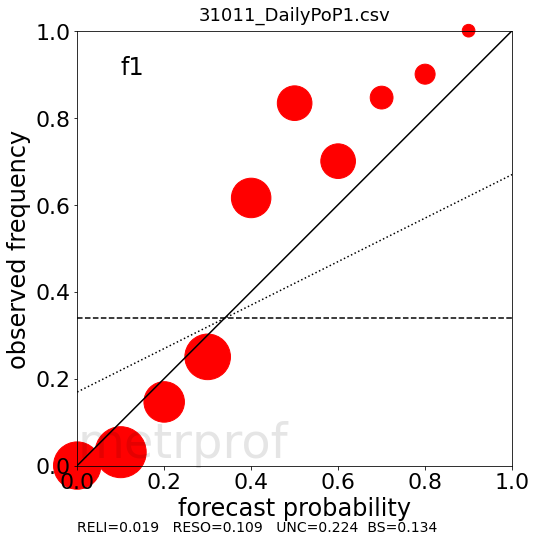

In [32]:
relidiag(verif,tag=fx,title=infilename,signature='metrprof')

## 3. For your Quiz.  
Submit your answers at our Canvas website.

In [33]:
contest={'c01': {0.4: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]},
 'c02': {0.5: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]},
 'c03': {1.0: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]},
 'c04': {0.0: [1, 0, 0, 0, 0], 1.0: [0, 1, 1, 1, 1]},
 'c05': {0.2: [1, 0, 0, 0, 0], 0.8: [0, 1, 1, 1, 1]},
 'c06': {0.2: [0, 0, 0, 0], 1.0: [1, 1, 1, 1, 0, 1]},
 'c07': {0.2: [0, 0, 0, 0, 0], 0.8: [1, 1, 1, 1, 1]},
 'c08': {0.0: [0, 0, 0, 0, 0], 1.0: [1, 1, 1, 1, 1]},
 'c09': {0.2: [1, 1, 0, 0, 0], 0.5: [0, 0, 1, 1, 1]},
 'c10': {0.0: [0,0], 0.1:[0,0,1], 0.8:[1,1,0],  0.9:[1,1]} 
        }

c01 {0.4: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]}
RELI=0.010   RESO=0.000   UNC=0.250  BS=0.260  

c02 {0.5: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]}
RELI=0.000   RESO=0.000   UNC=0.250  BS=0.250  

c03 {1.0: [1, 0, 0, 0, 0, 1, 1, 1, 0, 1]}
RELI=0.250   RESO=0.000   UNC=0.250  BS=0.500  

c04 {0.0: [1, 0, 0, 0, 0], 1.0: [0, 1, 1, 1, 1]}
RELI=0.040   RESO=0.090   UNC=0.250  BS=0.200  

c05 {0.2: [1, 0, 0, 0, 0], 0.8: [0, 1, 1, 1, 1]}
RELI=0.000   RESO=0.090   UNC=0.250  BS=0.160  

c06 {0.2: [0, 0, 0, 0], 1.0: [1, 1, 1, 1, 0, 1]}
RELI=0.033   RESO=0.167   UNC=0.250  BS=0.116  

c07 {0.2: [0, 0, 0, 0, 0], 0.8: [1, 1, 1, 1, 1]}
RELI=0.040   RESO=0.250   UNC=0.250  BS=0.040  

c08 {0.0: [0, 0, 0, 0, 0], 1.0: [1, 1, 1, 1, 1]}
RELI=0.000   RESO=0.250   UNC=0.250  BS=0.000  

c09 {0.2: [1, 1, 0, 0, 0], 0.5: [0, 0, 1, 1, 1]}
RELI=0.025   RESO=0.010   UNC=0.250  BS=0.265  

c10 {0.0: [0, 0], 0.1: [0, 0, 1], 0.8: [1, 1, 0], 0.9: [1, 1]}
RELI=0.024   RESO=0.117   UNC=0.250  BS=0.157  



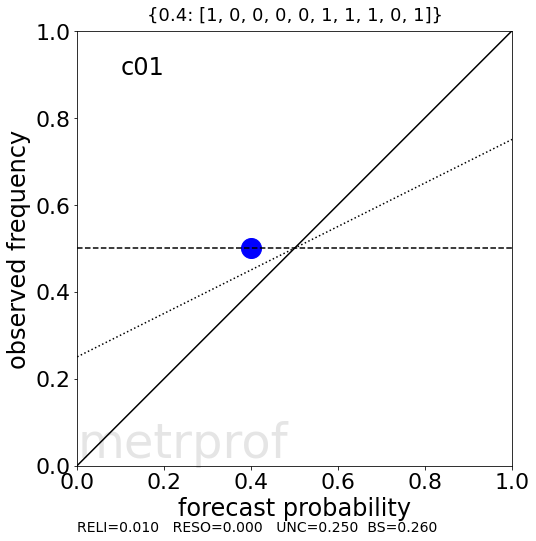

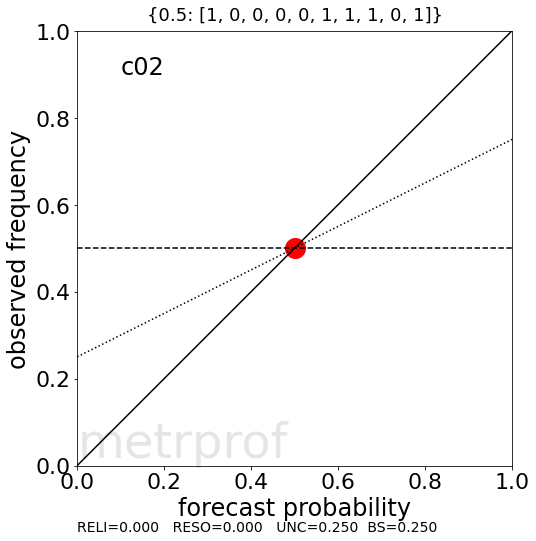

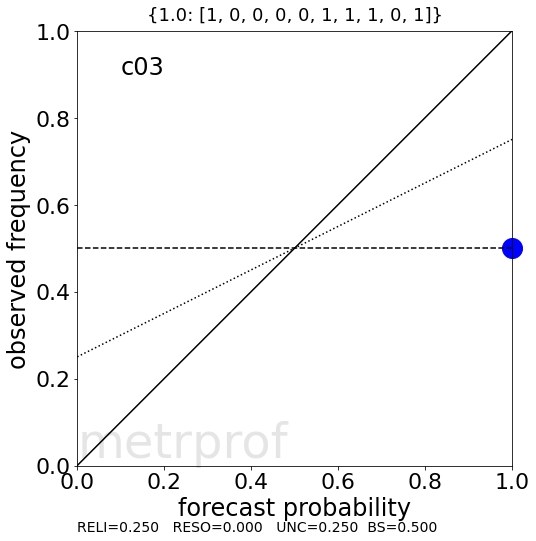

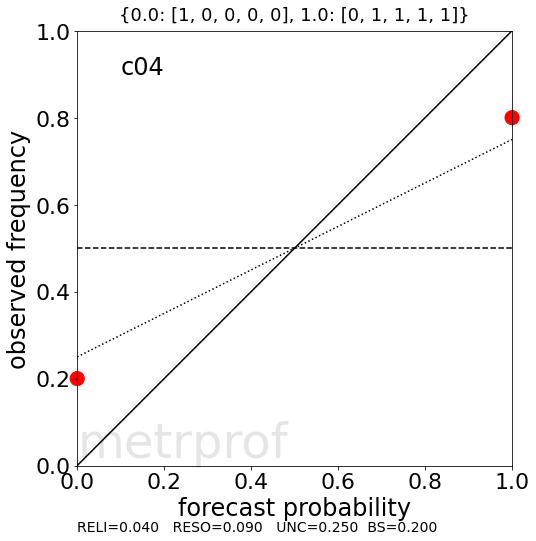

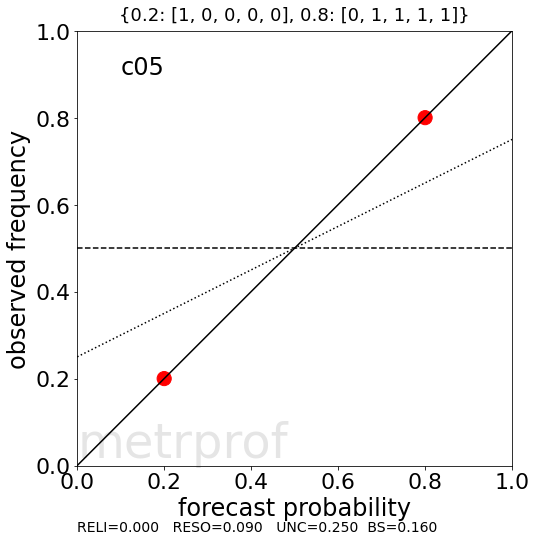

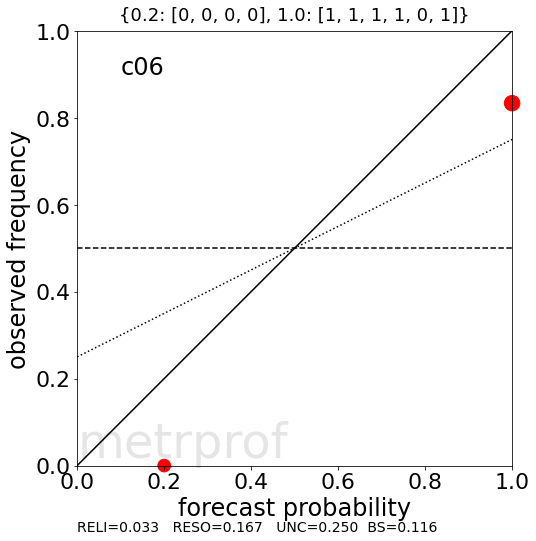

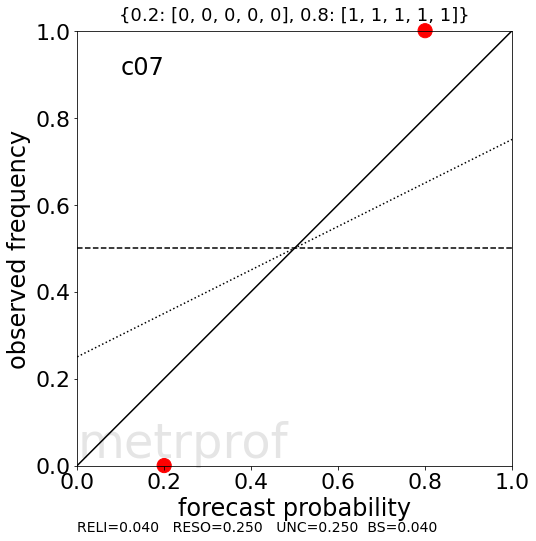

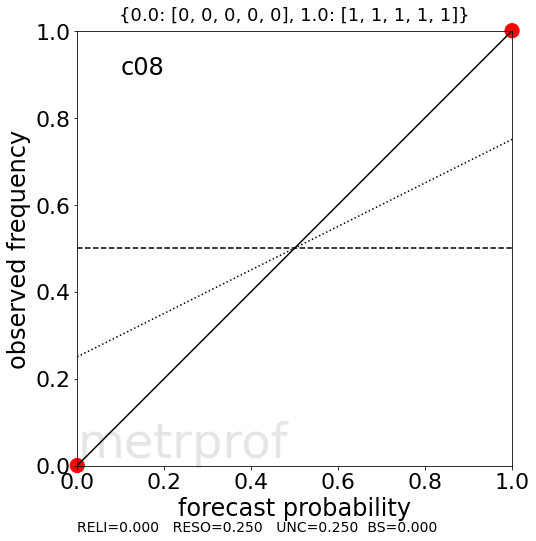

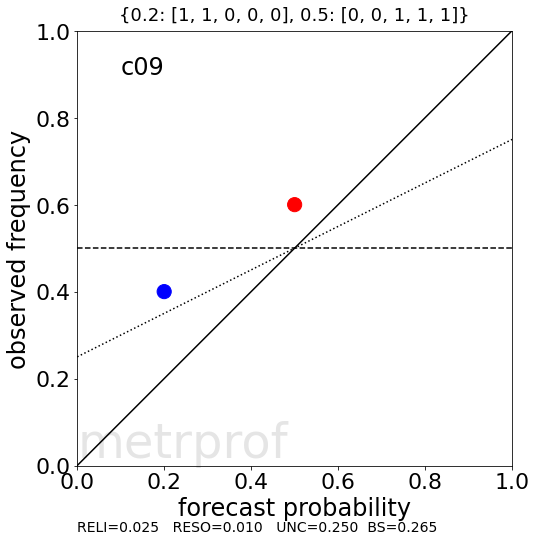

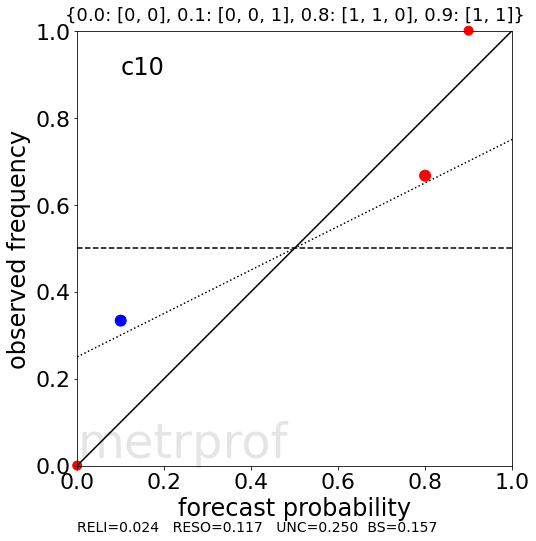

In [34]:
caption_form="RELI={:5.3f}   RESO={:5.3f}   UNC={:5.3f}  BS={:5.3f} "
for c in sorted(contest):
    e = contest[c]
    print(c,e)
    rel,res,un,bs = relidiag(e,tag=c,title=repr(e),signature=yourname)
    outstr = caption_form.format(rel,res,un,bs)
    print(outstr,"\n")


  # student quiz questions 
  
 Submit answers to the questions in **Canvas**.
 Note: In previous years, rain occurred in 4 out of 10 days on these dates.
  
 1. How many contestants have a value of $\mathrm{UNC}$ different from that of `c01`? 
  
 1. Which contestant made perfect forecasts? Enter `c01` or `co2` ... or `c10`.
  
 1. It is easy to show that using $p_1=\ob$ for all forecasts leads to $\mathrm{BS}=\mathrm{UNC}$. But using $p_1=\ob$ is not quite the same as using $p_1=p_{climo}$ because $\ob$, though close to $p_{climo}$, isn't known at
the time of the forecast. Using $p_1=\ob$, and beating $p_1=p_{climo}$ requires some luck in guessing what $\ob$ will be at the end of the contest.  Which contestant used $p_1=\ob$? 
 
 1. Which contestant used $p_1=p_{climo}$ for all forecasts? 
 
 1. Which contestant has the lowest value of bias? 
 
 1. There are three contestants tied for having the worst *resolution*. Of those three, which one has the worst *reliability*?  (Be careful about how the word *worst* would apply to those terms). 
 
 1. Of c04 and c07, which forecast is the best example of being under-confident? 
 
 1. Of c04 and c07, which forecast is the best example of being over-confident? 
 
 1. How many contestants have a Brier Skill Score $\mathrm{BSS} < 0$? (Using $\mathrm{BS_{climo}}$ from `c01`).
 
 1. Which contestant had one point showing no-skill, but a $\mathrm{BSS} > 0$? 
 
 
 
 
 

 

<hr style="height:30px;border:none;background-color:#0a0;" />

# Appendix
## Derivation of Brier score decomposition

Note that Wilks punts on the derivation in his 7.4.3 and says "After some algebra, ...". 

Well here it is! The "some algebra"!

$\newcommand{ob}{\overline{o}}$  $\newcommand{obk}{\overline{o}_k}$ $\newcommand{oki}{o_{ki}}$
\begin{eqnarray}
\mathbf{BS} &=& \frac{1}{N} \sum_{i=1}^N (p_i-o_i)^2
\end{eqnarray}

Let's group the $o_i$ with one particular value of $p_k$. For example, maybe $p_1=0.0$, $p_2=0.1$ and so on, to $K$ distinct values of $p_k$.
We assume there are $n_k$ values of $\oki$ associated with one $p_k$.

\begin{eqnarray}
\mathbf{BS} &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k} (p_k-\oki)^2\\
 &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k} (p_k -\obk + \obk-\oki)^2 \\
 &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k} \left[ (p_k -\obk) + (\obk-\oki) \right]^2 \\
 &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}  (p_k -\obk)^2 + \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}  2(p_k -\obk)(\obk-\oki) + \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}(\obk-\oki)^2 \\
\end{eqnarray}
The second double sum is zero, because: 
$$
\obk \equiv \frac{1}{n_k} \sum_{k=1}^{n_k}\oki
$$
The first double sum is exactly the *reliability* indicated in the above image.
We turn our attention to the last double sum, which eventually yields the *resolution* and *uncertainty*:

\begin{eqnarray}
\frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}(\obk-\oki)^2 &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}(\obk -\ob +\ob -\oki)^2 \\
 &=& \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}\left[ (\obk -\ob)^2 + 2(\obk -\ob)(\ob -\oki) + (\ob -\oki)^2 \right] \\
 &=& \frac{1}{N} \sum_{k=1}^K n_k (\obk -\ob)^2 + \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}2(\obk -\ob)(\ob -\oki) + \frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}(\ob -\oki)^2  
\end{eqnarray}

Onward to simplifying the last two double sums in the above 3.

We again use the definition of $\obk$. Thus the second double sum is -2 times the first:

\begin{eqnarray}
\frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}2(\obk -\ob)(\ob -\oki) &=& \frac{2}{N} \sum_{k=1}^K (\obk -\ob)\sum_{i=1}^{n_k}(\ob -\oki)\\
&=& \frac{2}{N} \sum_{k=1}^K (\obk -\ob) n_k(\ob -\obk)\\
&=& - \frac{2}{N} \sum_{k=1}^K n_k (\obk -\ob)^2 \\
\end{eqnarray}

All of the $\oki$ have a value of either 1 or 0. There are $N$ such values.  There is no need to be partitioning the sum over the various $k$, since there is no $p_k$ in the expression.
But there is an advantage to arrange the sum over the $N_1$ values where $o_i=1$, and the $N-N_1$ values where $o_i=0$.

\begin{eqnarray}
\frac{1}{N} \sum_{k=1}^K \sum_{i=1}^{n_k}(\ob -\oki)^2 &=& \frac{1}{N} \sum_{i=1}^{N}(\ob - o_i)^2 \\
&=& \frac{1}{N} \left[ N_1 (\ob - 1)^2  + (N-N_1) \ob^2 \right] \\
&=& \frac{1}{N} \left[ -2 N_1 \ob + N_1  + N \ob^2 \right] \\
&=&  \left[ -2 \ob^2 + \ob  + \ob^2 \right] \\
&=&   \ob  - \ob^2  \\
&=&   \ob(1  - \ob)  \\
\end{eqnarray}
In the final steps we have used the fact that:
$$
\ob = \frac{N_1}{N}
$$

So now we have $\mathbf{BS}$ decomposed into three sums: *reliability*, *resolution* and *uncertainty*. Our Python function uses the first form of $\mathbf{BS}$, but the decomposition aids in interpreting the result.

\begin{eqnarray}
\mathbf{BS} &=& \frac{1}{N} \sum_{i=1}^N (p_i-o_i)^2\\
&=& \frac{1}{N} \sum_{k=1}^K  n_k (p_k -\obk)^2 - \frac{1}{N} \sum_{k=1}^K n_k (\obk -\ob)^2 +  \ob(1  - \ob) \\
&=& \mathbf{RELIABILITY}-\mathbf{RESOLUTION}+\mathbf{UNCERTAINTY} \\
&=& \mathbf{RELI}-\mathbf{RESO}+\mathbf{UNC} \\
\end{eqnarray}

Note, this warning: 
> "The presence of the uncertainty term means that Brier Scores should not be compared on different samples."

I will express that differently: It is relatively easy to get low Brier scores for forecasts of events that are either very frequent,  $\ob \approx 1$, or very rare $\ob \approx 0$.  Though forecast systems for such events will produce a low $\mathrm{BS}$, they are not necessarily better, more clever, or more skillful than  forecasts systems that produce higher $\mathrm{BS}$ for a different type of event with $\ob \approx 0.5$.

So we turn to calculating a [Brier skill score](http://www.cawcr.gov.au/projects/verification/#BSS) to determine how valuable our forecast system really is.

$$
\mathrm{BSS} = \frac{
\mathrm{BS}_{\mathrm{forecast}} - \mathrm{BS}_{\mathrm{climo}} 
}
{
\mathrm{BS}_{\mathrm{perfect}} - \mathrm{BS}_{\mathrm{climo}}
}
= 
\frac{
\mathrm{BS}_{\mathrm{forecast}} - \mathrm{BS}_{\mathrm{climo}} 
}
{
0 - \mathrm{BS}_{\mathrm{climo}}
}
=
1 -
\frac{
\mathrm{BS}_{\mathrm{forecast}} 
}
{
\mathrm{BS}_{\mathrm{climo}}
}
$$



## The "no-skill" line

For a given $k$, $\obk$ is increasing $\mathrm{BS}$, and so decreasing skill, when:

$$  (p_k -\obk)^2 > (\obk -\ob)^2  $$

which simplifies to:

$$  (p_k + \ob) (p_k - \ob) > 2\obk(p_k -\ob) $$

So when $p_k > \ob$, decreasing skill occurs for points:

$$ \obk < \frac{p_k+\ob}{2} $$
And when $p_k < \ob$, decreasing skill occurs for points:

$$ \obk > \frac{p_k+\ob}{2} $$

## Encrypted Answers

In [35]:
from cryptography.fernet import Fernet
#I already did this:
#newkey = Fernet.generate_key()
#with open("secretnew.key", "wb") as key_file:
#    key_file.write(newkey)
with open("unlockit.key",'rb') as keyfile:
    secretkey=keyfile.read()
hideit=Fernet(secretkey)
#here is how I hid the answers:
#hdn=hideit.encrypt(answer1.encode())
#hdn

In [36]:
#hdn=hideit.encrypt(answer1.encode())
#hdn

In [37]:
goodluck1=b'gAAAAABiO1vlC_ouuxtwsARH9j8fw2s4IITFZtCp1wCEy-mXooaMtouCTsZCpCn3z6rHyccYy4Zgdi_7XIiTxsjdQZYJTa76VcDoFIxgOfDW4oETo0LWdakd5GxCZBbcxZSjJX0HyBV9i_9dkhQL0QxLwhYzvR7rOk5QlKii8u73nVLMMxm6gxqOFY0fuphn2h2PP9qZ-v3wF6_cWpoidNCkiv8qjoAAd_dXBMgB9A9MKVe_eEotUTmBZxNGAiHH5B4QDaDHhBTSV2O5x9LqcvVx0tiDhthQf_aG_Ep7hFYgf_GnJeha9XyAAKeetu8l39mcxzXtyCmW-00pOrHasaDuYsKzp2CKo5DSLMR4MDFWgR0WGs6Rh0ZO04YiPPyaJpvrXcmkgmuO242V5SEhjTB8ZegCPP7yZ9uYSqPHkBzRvjwoCQ1SW7Gw-0yEZVrTdetIGfHGZnTmb-wEP27pqpySewRskVVcqk6vKNjhzWdLlazjBP70tGX6yHs7PVEUiKVmoXhuAwmo_7kwrFhyOWP-YX84G_-63IWtqJAXBFrPNUgeNztJrwUDKtA0kOKIgU8jeuNmr4YePUkZeg89BPRLQN8MuOwDkDjI1SxtK6okDXoki23qxR9Q03rxdpvlW-AIsk8cQvW0tVum1x8VG7IE73tM0OtYpnWoERY7foK3BTcz3rHuIDz5x506aAwWwQisXcCT_p4eR9JZAU53KccuI10l_ZqeDK4naepNeIGYkAFxy_qSoHYnI2nkQCfqMmm4aAijk0c8omhx3dL2omHsTlJ3ZZW2S19yJ1iR0n_ePy0oGisLf41p1qyPageX1hXLiiiDccjWg63d0XqRK5KB9Kq2Hv94mReRzoMj5VOF2GcX8TdlKjKRzNSHP6wJcOwJQin429Kd'

In [38]:
#print(hideit.decrypt(goodluck1).decode())

In [39]:
goodluck2=b'gAAAAABiRFr1KSIvEkQ3IO6m4wYqUYS5UrRyR6n0YVEzwWIcz6xFUC8P8uj4PyQ1e9VdSrhdudwX3TgncTzBe60G2AzAAvFt_alRMq6XsXIkfQX5JXCam1MkL3mcyaTh-SfHQQjaZHgKYa9RTWbpZ21O2j1qxFc3uFuE3sEseGhdM40gwD-mDQ_pBWF3g0QeO5wIh4O1MZ4Ix-mkSNqu1d5FaddghW-gusWw9H6VGq1rdUfmturMZsM-cG0gYqB2TGtxxvomkEgPvQL6MuMlLF74B3UqySyHsg4yNASX_STFzg0mjbg4wIcuG4sC3m8CLudzpcdyriite_ObBza9kRuwyxuUdgnezKLtCzjKbt8hOOxHHbkSg2qmJu3fJou0JXuYq2jOWNqUSX5IgJnNPHEzg1ETw1pTI8SK3wI3gxd6KRHFcNu8YRrYqHNolK__I2tmowgZ5M8gqfMnuAAwu_dzMb0AAKyHHO8bYdMhpMSdp1LS7YWmLhYOLS5GsyvI2c-vcWi_U_RoZoc8onFjWZDiVFpMVn5Lvqsl6nz0V3D4COWfhYV5k7M9wTzPkD44WazHXqxpir02qMvGty4wuV33esDNzwPrJ4N9i0y1mwbuECyb0ZZX-30usbHE537nKmX2HNYmqOu8PWT4WNAGWGqiNX2QiMedNQpwSJNXWGv63hLbYr8RuhSjgC3RFrbGGrS9YTlknafVjUTG6fLjJmE92R0pZdndVgYisGQmrWrJ0u4KzeE4-EymeQRT4ueC8oQdccuymD3A_zK_xC6X1-7mnjaKYvVzz5cl5-O9Rs96i3McKm17Ei8p046d4PGL93TQwP8Cf4iiPlZ18xJgU1ivLNdCwszrpjlB4dqfvhnsJlKbq_HObhoA_dYy9buGPslyfShsTlEezhqIoU6f421a9A-tLibkQdUvSuQQplH2PKKPVPkPkWKjxwh-Tc3PLYvc4hodFIFNfkhMN1vSqwxCd80aaApvB3uji13p0cDueeUe7J_11xTpffhrCehNTf1EYt4ngcEHun-HIcmUelixnp2nxDXHCRaG8pxKLtW9_uIdO0rnA4HxFkozXhxyHS2oMx5LVEQ91ymLG9MhnOzHxuBZd0PphVELuedLXYJDVqvYsRzZZ6J5sdVlbxbtlwQtFt1jouW0c0hmxbdG7Nvd47GazFVGahYXlW2l9WkCAIGIhI1p--zkRi-_Mk1QJE257tsDGw6RNiBsqVq9CRPalajyVh2pR6q1q1UzUtYpoX035hk-3uzZzSFTNrE7swkG-rs37S3hzYQ5eXFIQDCW8dBthBCUOTrgFDWpHm2CijtS9kj4w6rYMLf0gokM2ii-r1tkuCMrw5HtDccOZa_0tLR8t3Jvrxa8eBfpH23SQRjYYlzEhyIAMcTyu0jocozthykA-lA079jQIDmI0UPvsYa_R-zXC-i79xSbF_z9LNOtaDVTBBq9iiU136AmPHL2iuWBhmq0rX9mm8UKKh5ZJfj_Rs2Rq-16QuxZ2hoj_uHkOqGRJZTNMu9bY0BEHOtNf4IaYY8oHAJmEHLm7yCrMr7x_qG1tVeOGxCQwD6QAh-DKEInzyZlfCMnjSOAYCmKmbJaXFk55wk1rSUAc2HRxBfaXU_HL5dHc0dYb8mDJkX6Ph9Byk9CbhfhTAF3c7wtdqWLvOcqFpDHYWRDoWYC0yJT8NPNBwKsJcdbY7BRhzoQ9xz6XOaSYaqub18HU9wAbI5EG9J53Lrk8EPrUOtOFjymEadpTOX5dezTMbQot6_ZInHsK-kEIqSrnZLGKiMSGN7VCGLjnjXjvXtoH38w5Qa2BHjC_LSljSmpuribiteobzLzg1VDxotThXWwze-wHOsySe07ZuHdd2Eam-O4JFcJNX7YrqOEC5QvGSO0HMAwn245flLENVcevmtoFxjKf8yAEYIzgA5X2ColwNQCMDuk14YpLNp2UEAUiiWBA8beSZSsZmmoTU9e2Ooxt3ngZPVJzAtWJ2rw5_pw1HsGmPOE6KvUaSGnfznxofhO0lo4Kxk-wLtX1qLMh33D86kbRLE2uXpKDFezMPLSq75Xz34S4XAKvICtV2GW4KfQ3PncXnGiDRrzG25X4uOZ9zz0r91qx4zJUMbM5sHAenA1h2gIfguG_1-T6NqRlBiGiTXfuNnyeNZLHMm_f8VSZBPLMpPUSgn062rh8EomBT_8QvA3mDdCS2Vo6laxeKdhzw0D-qHTcHf8n5i9U8AN0rqwS6lEJTu2iCL_iWDPv0aDORpd4dg8G9D1jSic5_ic6IGSsFDF83tfhxku6mQ_C5Jz6P-Ei3d9i9LnO3ogIGpskNYygdTZQi1RhaOat3SqZ67_t93TnrVWs8q2ZhLH1QXg-rIkYjcssNWGY4O8pBFAfQModq_Xkg33kgYpIyqWCtKawbINEIQENH-Hk1xzj9opYJ7bk3osCHMMDtUwI_t5G517-BsWN92MgMJOo3ATpxATtBWIMwpkxGNLS5XkP0XtwMww0QjFWSoEZtlMrU6tkFZouIeP7gqPe59E-LA-1tfEkL5opFGMdHbNX-Zv2jZWezev2BjKwxotq1hCvg3QArJ6z5iSvmqXspyyxI_nAcFUo8j0blji16tShk9cmEtCku7SYvQh8_KwNAls_38EkCWlHyhzJXi0vtmbMdoJf9rwSDz_UDrHi9ZSPIE61XuyZ4dzqTmjJMGCC48J_WgM2iV3GPwDYPCayrs5ldG-ZBTrjv80gBiVzR2I53YsZCxSIxQ2KcDqbwJ8pstpgfyAxBH6RAW1ugy7Epw7pRaV3R40VCurCPtGIWoKM_x1A1MZ0kIOJsIqFT1-58I7gXKEgAiDRqmjHu99kz4Mt-nfTUlDxzjgbOmU5s1-cVlI5Hs3TwOoSnAb1WtKG6nR870eTtwIgDgyNiHrtZbknggEyppWy20TVX7Ox59SNoXoKF0h4qBut6OaX3Jw2iuHfexBmgmstluhM5ngoHZrw_JXxiASgOAsJfinQH_4C2wBuO_oCnXeHaVR9PObvAjKWpjP3k711D1MhqDKVJaXL6Iy7IZyGGlL5cVK3Hi9NsA6hcm3ZNcD9stsmYzA7mKt3J2i6VKAzJy_60EjkMXKaeZEUny2IBOVrz1iwyAZlQFUU9JzyBNfOs-5HBYGtvUWmf9y83afUKHevpN7Fople8GI6RwinqXVX1g5nTSJo4eNA2j1pTLYkHMJuIaSpESypsU8X9sGbX1ff-5S3jlJx4-VU9wy0_OUOoduh-GfasN22MELsHLP7OejjmHsgjMJAVxv7GQtDXw9JbLF3I7RF2zo6bL5kGNJP7nBnmB-9xcOE_4b9YOc1QZt467CllWIsNLV1_uf5j4k56oxfiu_xs6OZ1YI76rL68t891cUyt__M2OWFAW3YMuFt5YHzNe31fxWHpVXL-SQcCAf7VM0gPu9NeVlWQR3XuwLdQ1MAolkPXpRpFieJiFdvR6TDD5WfRBt-MtqLImZRHsbB9_PM4tW7fyKfdtqY15oQyjgRTmOTgEZ84KymZqBloYdhJmOwsLbN_iyCZaXmg=='

In [40]:
#print(hideit.decrypt(goodluck2).decode())